# An example of using EASYMORE with rotated Latitude and Longitude (every grid has it own lat and lon)
## Remapping of CONUS WRF to subbasins of South Saskatchewan River at Medicine Hat, Alberta, Canada.

In [1]:
# loading EASYMORE
from candex.candex import candex

# initializing EASYMORE object
cndx = candex()

# specifying EASYMORE objects
# name of the case; the temporary, remapping and remapped file names include case name
cndx.case_name                = 'WRF_Medicine_Hat'
# temporary path that the EASYMORE generated GIS files and remapped file will be saved
cndx.temp_dir                 = '../temporary/'
# name of target shapefile that the source netcdf files should be remapped to
cndx.target_shp               = '../data/target_shapefiles/South_Saskatchewan_MedicineHat.shp'
# name of netCDF file(s); multiple files can be specified with *
cndx.source_nc                = '../data/Source_nc_WRF/WRF*.nc'
# name of variables from source netCDF file(s) to be remapped
cndx.var_names                = ['T2']
# name of variable longitude in source netCDF files
cndx.var_lon                  = 'XLONG'
# name of variable latitude in source netCDF files
cndx.var_lat                  = 'XLAT'
# name of variable time in source netCDF file; should be always time
cndx.var_time                 = 'time'
# location where the remapped netCDF file will be saved
cndx.output_dir               = '../output/'
# format of the variables to be saved in remapped files,
# if one format provided it will be expanded to other variables
cndx.format_list              = ['f4']
# fill values of the variables to be saved in remapped files,
# if one value provided it will be expanded to other variables
cndx.fill_value_list          = ['-9999.00']
# if exists and uncommented EASYMORE will use this remapping info and skip GIS tasks
#cndx.remap_csv                = '../temporary/WRF_Medicine_Hat_remapping.csv'

# execute EASYMOREcandex
cndx.run_candex()



no author name is provide and the author name is changed to (author name)!
EASYMORE will remap variable  T2  from source file to variable  T2  in remapped NeCDF file
EASYMORE detects that target shapefile is in WGS84 (epsg:4326)
EASYMORE detects that no field for ID is provided in sink/target shapefile
arbitarary values of ID are added in the field ID_t
EASYMORE detects that either of the fields for latitude or longitude is not provided in sink/target shapefile
calculating centroid of shapes in equal area projection
point shapefile for centroid of the shapes is saves here:
../temporary/WRF_Medicine_Hat_centroid.shp
EASYMORE detects that no field for latitude is provided in sink/target shapefile
latitude values are added in the field lat_t
EASYMORE detects that no field for longitude is provided in sink/target shapefile
longitude values are added in the field lon_t
it seems everything is OK with the sink/target shapefile; added to EASYMORE object target_shp_gpd
EASYMORE will save standa

/Users/shg096/opt/anaconda3/envs/myenv/lib/python3.8/site-packages/candex/candex.py:145: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files


------REMAPPING------
Remapping ../data/Source_nc_WRF/WRF_merged_2000-10-01.nc to ../output/WRF_Medicine_Hat_remapped_2000-10-01-00-00-00.nc
Started at date and time 2021-04-16 15:32:11.655547
Ended   at date and time 2021-04-16 15:32:11.841564
------


--------------
--------------
# Visualization of the source and the results

/Users/shg096/opt/anaconda3/envs/myenv/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<xarray.DataArray 'T2' (time: 24, y: 168, x: 199)>
[802368 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 2000-10-01 ... 2000-10-01T23:00:00
    XLONG    (y, x) float64 ...
    XLAT     (y, x) float64 ...
Dimensions without coordinates: y, x
Attributes:
    units:        K
    FieldType:    104
    MemoryOrder:  XY 
    description:  TEMP at 2 M
    stagger:      


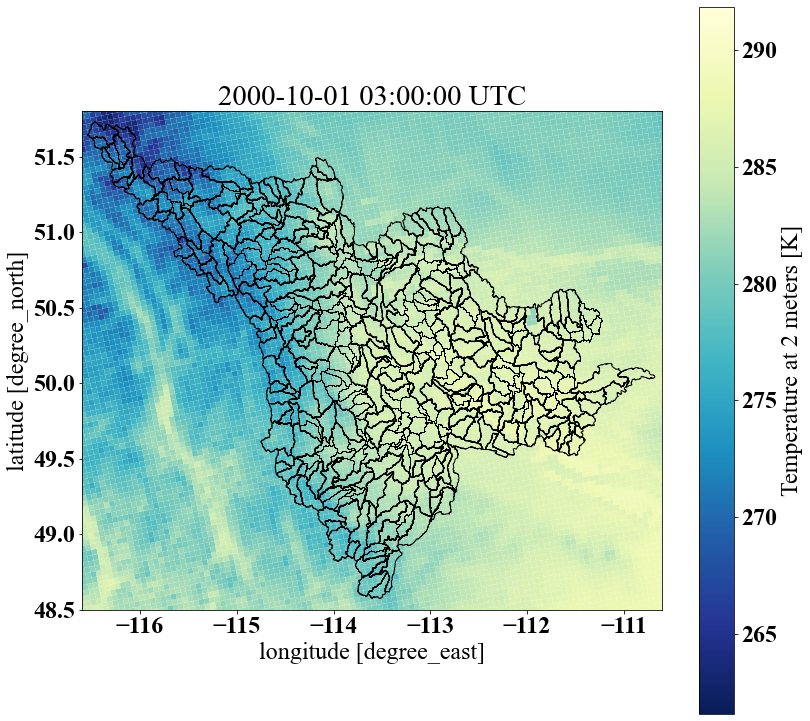

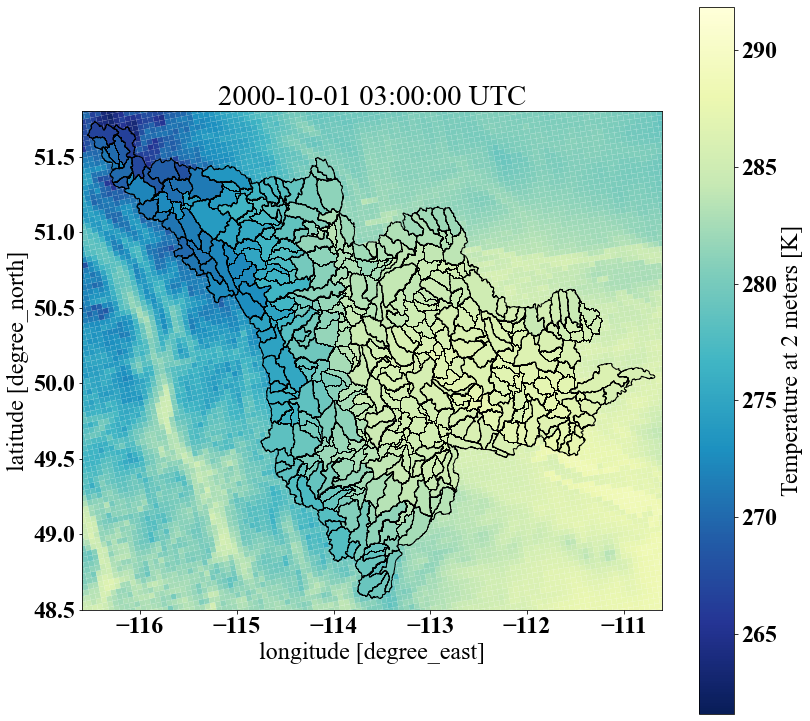

In [2]:
# visualize the result
import geopandas as gpd
import xarray as xr
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from datetime import datetime

import matplotlib
font = {'family' : 'Times New Roman',
         'weight' : 'bold',
         'size'   : 24}
matplotlib.rc('font', **font)



# visualize the original netCDF for the first file, first time step
shp_source = gpd.read_file(cndx.temp_dir+ cndx.case_name + '_source_shapefile.shp') # load the target shapefile
# load the infromation on the
nc_names = sorted(glob.glob (cndx.source_nc))
ds       = xr.open_dataset(nc_names[0]) # the first netcdf file
print(ds.T2)


time_str = "2000-10-01 03:00:00 UTC"


T2       = np.array(ds.T2 [3,:,:]).flatten() # the first time frame of the first 
lat      = np.array(ds.XLAT).flatten()  # the first time frame of the first 
lon      = np.array(ds.XLONG).flatten()  # the first time frame of the first 

lat_shp = shp_source ['lat_s']
lon_shp = shp_source ['lon_s']
idx = np.zeros(len(lat_shp))
value = np.zeros(len(lat_shp))

for i in np.arange(len(lat_shp)):
    # find the row of the shapefile that is closes to the point
    diff = abs(lat-lat_shp[i])+ abs(lon-lon_shp[i])
    temp = np.where(diff == np.min(diff))
    idx[i] = temp[0].astype(int)
    a = idx[i]
    value[i] = T2 [a.astype(int)]


shp_source ['value'] = value

# # create the colorbar
norm = colors.Normalize(vmin=shp_source.value.min(), vmax=shp_source.value.max())
cbar = plt.cm.ScalarMappable(norm=norm, cmap='YlGnBu_r')

# plot
fig, axes = plt.subplots(1,1,figsize=(13,13))

# with no normalization
shp_source.plot(column='value', cmap='YlGnBu_r', legend=False, ax=axes)

# add colorbar
ax_cbar = fig.colorbar(cbar, ax=axes)
# add label for the colorbar
ax_cbar.set_label('Temperature at 2 meters [K]')

plt.xlim([-116.6 , -110.6 ])
plt.ylim([48.5 , 51.8 ])

plt.xlabel('longitude [degree_east]')
plt.ylabel('latitude [degree_north]')
plt.title(time_str)

shp_target = gpd.read_file(cndx.temp_dir+ cndx.case_name + '_target_shapefile.shp') # load the target shapefile
shp_target.geometry.boundary.plot(color=None,edgecolor='k',linewidth = 1, ax = axes)


plt.savefig('../fig/Example2_A.eps')


#

# visualize the remapped netCDF for the first file, first time step
# target nc file
nc_names = sorted(glob.glob (cndx.output_dir + cndx.case_name + '*.nc'))
ds       = xr.open_dataset(nc_names[0]) # the first netcdf file
values   = ds.T2 [3,:] # the first time frame of the first 
IDs      = ds.ID [:] # get the ID
# create a data frame for the model simulation
df = pd.DataFrame()
df ['value'] = values
df ['ID_t']    = IDs  # .astype(int)
df = df.sort_values (by = 'ID_t')
# load the shape file target that is generated by EASYMORE (with consistent IDs)
shp_target = gpd.read_file(cndx.temp_dir+ cndx.case_name + '_target_shapefile.shp') # load the target shapefile
shp_target ['ID_t'] = shp_target ['ID_t'].astype(float)
shp_target = shp_target.sort_values(by='ID_t')# sort on values
shp_target = pd.merge_asof(shp_target, df, on='ID_t', direction='nearest')
shp_target = shp_target.set_geometry('geometry') #bring back the geometry filed; pd to gpd


# plotting

# # create the colorbar
norm = colors.Normalize(vmin=shp_source.value.min(), vmax=shp_source.value.max())
cbar = plt.cm.ScalarMappable(norm=norm, cmap='YlGnBu_r')

# plot
fig, axes = plt.subplots(1,1,figsize=(13,13))

# with no normalization
shp_source.plot(column='value', cmap='YlGnBu_r', legend=False, ax=axes)

# add colorbar
ax_cbar = fig.colorbar(cbar, ax=axes)
# add label for the colorbar
ax_cbar.set_label('Temperature at 2 meters [K]')

plt.xlim([-116.6 , -110.6 ])
plt.ylim([48.5 , 51.8 ])

plt.xlabel('longitude [degree_east]')
plt.ylabel('latitude [degree_north]')
plt.title(time_str)

shp_target.plot(column= 'value', cmap='YlGnBu_r', edgecolor='k',linewidth = 1, ax = axes , vmin = np.min(T2), vmax = np.max(T2))#, legend=True)

plt.savefig('../fig/Example2_B.eps')


